# INTRODUCTION

### Libraries

In [1]:
import os
import datetime
import IPython

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

import keras_tuner as kt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Import data & column groups

In [2]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

# Drop lag columns and date from data
df = df.drop(columns=lag_cols + ['date'])

print("Unique data types in df", df.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in df
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()
num_features = df.shape[1]

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")
print(f"\nAll columns accounted for: {len(categorical_cols) + len(numeric_cols) == num_features}")

Unique data types in df
float64    40
object     11
int64       7
float32     4
int32       2
Name: count, dtype: int64

Categorical columns: ['covid', 'month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter']
Numeric columns: ['ordinal_date', 'year', 'day_of_month', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr', 'flights_dep', 'flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E', 'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E', 'flights_arr_cancel', 'flights_arr_delay', 'flights_arr_ontime', 'flights_dep_cancel', 'flights_dep_delay', 'flights_dep_ontime', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed

### Split data sequentially 70/20/10

In [3]:
n = len(df)
train_raw = df[0:int(n*0.7)]
val_raw = df[int(n*0.7):int(n*0.9)]
test_raw = df[int(n*0.9):]

# print data shapes
print(f"Train data preprocessed shape: {train_raw.shape}")
print(f"Validation preprocessed data shape: {val_raw.shape}")
print(f"Test data preprocessed shape: {test_raw.shape}")

Train data preprocessed shape: (1179, 64)
Validation preprocessed data shape: (337, 64)
Test data preprocessed shape: (169, 64)


### Preprocess data for recurrent neural network time series

In [4]:
scale_cols = [col for col in numeric_cols if col != 'flights_ontime']

# Fit transformers to the training data
scaler = StandardScaler()
scaler.fit(train_raw[scale_cols])

# Create a scaler to enable inversing scaling of the flights_ontime column
# flights_ontime_scaler = StandardScaler()
# flights_ontime_scaler.fit(train_raw[['flights_ontime']])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(train_raw[categorical_cols])
ohe_column_names = ohe.get_feature_names_out(input_features=categorical_cols)

def preprocess(data):
    scaled_features = scaler.transform(data[scale_cols])
    encoded_features = ohe.transform(data[categorical_cols])
    processed_data = pd.DataFrame(np.concatenate([scaled_features, encoded_features, data[['flights_ontime']]], axis=1),
                                  columns = scale_cols + list(ohe_column_names) + ['flights_ontime'])
    return processed_data

train_df = preprocess(train_raw)
val_df = preprocess(val_raw)
test_df = preprocess(test_raw)

print(f"\nNumber of columns before preprocessing: {num_features}")
print(f"Number of features after preprocessing: {train_df.shape[1]}")


Number of columns before preprocessing: 64
Number of features after preprocessing: 105


## WindowGenerator
The `WindowGenerator` class stores the train, validate, and test sets (Pandas DataFrames), and it handles indexes and offsets for windowing. Several methods are added to this class after its creation. When the `split_window` method is added, the class will split data windows into separate tensors for features and labels. The `plot` method, produces a plot of an example batch showing inputs, labels, and predictions. The `make_dataset` method creates TensorFlow timeseries datastes that are batched, windowed, and ready for use in modeling.

In [5]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

class WindowGenerator():
  """
  A class to hold train, validate, and test sets and manage windowing and conversion to TensorFlow time series datasets

  Attributes:
    input_width (int): The number of time steps to include in the input window
    label_width (int): The number of time steps to include in the label window
    shift (int): The number of time steps to shift the label window to create the next input window
    train_df (pd.DataFrame): The training data
    val_df (pd.DataFrame): The validation data
    test_df (pd.DataFrame): The test data
    label_columns (list): The columns to predict

  Methods:
    __init__(input_width, label_width, shift, train_df, val_df, test_df, label_columns)
    __repr__() # Return a string representation of the window
  """

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
               
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Instantiate WindowGenerators

In [6]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['flights_ontime'])

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                        label_columns=['flights_ontime'])

## Add split_window method

In [7]:
def split_window(self, features):
  """
  Given a window of features, the method splits the features into inputs and labels

  Args:
  features: A window of features

  Returns:
  inputs: A window of input features
  labels: A window of label features
  """

  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# Add the method to the class
WindowGenerator.split_window = split_window

Demonstrate split_window on an example batch of 3 windows

In [8]:
# Stack three slices, the length of the total window. This creates an example batch of 3 windows, each of 7-timesteps and 105 features
example_batch = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_batch)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_batch.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 105)
Inputs shape: (3, 6, 105)
Labels shape: (3, 1, 1)


Create an "example" attribute for w2 and add the example batch inputs and labels. Later, we will add an example property for automatic creation of example batches that can be plotted.

In [9]:
w2.example = example_inputs, example_labels

## Add plot method
The plot method shows inputs, labels, and predictions for an example batch.

In [10]:
def plot(self, model=None, plot_col='flights_ontime', max_subplots=3):
  """
  Given a model and a column to plot, the method plots the inputs, labels, and predictions

  Args:
  model: A trained model
  plot_col: The column to plot
  max_subplots: The maximum number of subplots to display

  Returns:
  """

  inputs, labels = self.example
  
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')

    # Plot inputs
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    # Plot labels
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    # Plot predictions
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

# Add the method to the class
WindowGenerator.plot = plot

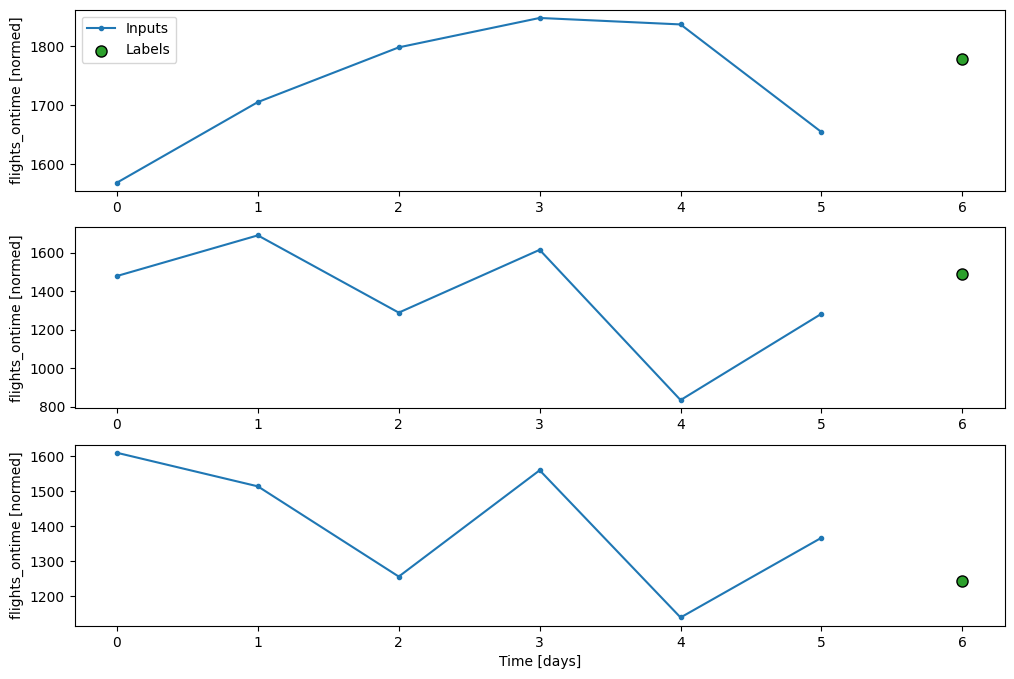

In [59]:
w2.plot()

## Add make_dataset

The make_dataset method creates TensorFlow timeseries datasets from the data objects held by WindowGenerator. The split_window function is mapped over the windows of the TensorFlow datasets, creating inputs and labels for each window. 

In [12]:
def make_dataset(self,data, seed=42):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        seed = seed,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

# Add the method to the class
WindowGenerator.make_dataset = make_dataset

# Define getter methods to datasets within WindowGenerator
Add properties for accessing the train, validation, and test datasets as TensorFlow timeseries datasets created by make_dataset. The `@property` decorator is used to define getter methods for properties of a class, allowing access to the result of a method as an attribute of the class. Properties are a special kind of attribute that are accessed like attributes but they execute class methods when getting, setting, or deleting the property value.

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Inspect an element of a tf.data.Dataset of w2 using the element_spec attribute

In [14]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 105), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

 Iterating over a tf timeseries dataset produced and held within a WindowGenerator instance, e.g. `w2.train` produces batches of data, where each batch has input and labels tensors.

In [15]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time steps, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time steps, features): {example_labels.shape}')

Inputs shape (batch, time steps, features): (32, 6, 105)
Labels shape (batch, time steps, features): (32, 1, 1)


## single_step_window instance

In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['flights_ontime'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['flights_ontime']

Like for w2.train, iterating over single_step_window.train produces batches of two Tensors, inputs and labels. w2 used 6 steps in the input and single_step_window uses 1.

In [17]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 105)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline
The `Baseline` class inherits from `keras.Model` and uses the current value of a label to predict a label one step (one day) into the future, ignoring all other information. We hope to beat this model with a LSTM recurrent network that considers current and recent values of the label and other features.

In [18]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

The baseline model of using the previous day's ontime flights to predict the next day's ontime flights produced MSE and MAE validation set scores of 46363 and 140 respectively. Again, we'll try to beat these with a LSTM recurrent network.

In [19]:
baseline = Baseline(label_index=column_indices['flights_ontime'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])

y_true = val_df['flights_ontime'].iloc[:-1]
y_pred = val_df['flights_ontime'].shift(-1).dropna()

val_performance = {
    'baseline_Keras_evaluate' : {
        'MSE': baseline.evaluate(single_step_window.val, verbose=0)[0],
        'MAE': baseline.evaluate(single_step_window.val, verbose=0)[1],
        'MAPE': baseline.evaluate(single_step_window.val, verbose=0)[2]
    },
    'baseline_Sklearn' : {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }
}

print("Validation performance:")
print(pd.DataFrame(val_performance).T.round(2))

Validation performance:
                              MSE    MAE   MAPE
baseline_Keras_evaluate  46363.16  140.4  14.13
baseline_Sklearn         46363.15  140.4   0.13


Below we create a wider window of 28 days (4 weeks) for visually evaluating the baseline model. This won't change the performance metrics, because we are still using the baseline model. 

In [20]:
wide_window = WindowGenerator(
    input_width=28, label_width=28, shift=1,
    label_columns=['flights_ontime'])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

print('\n', wide_window)


Input shape: (32, 28, 105)
Output shape: (32, 28, 1)

 Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Label column name(s): ['flights_ontime']


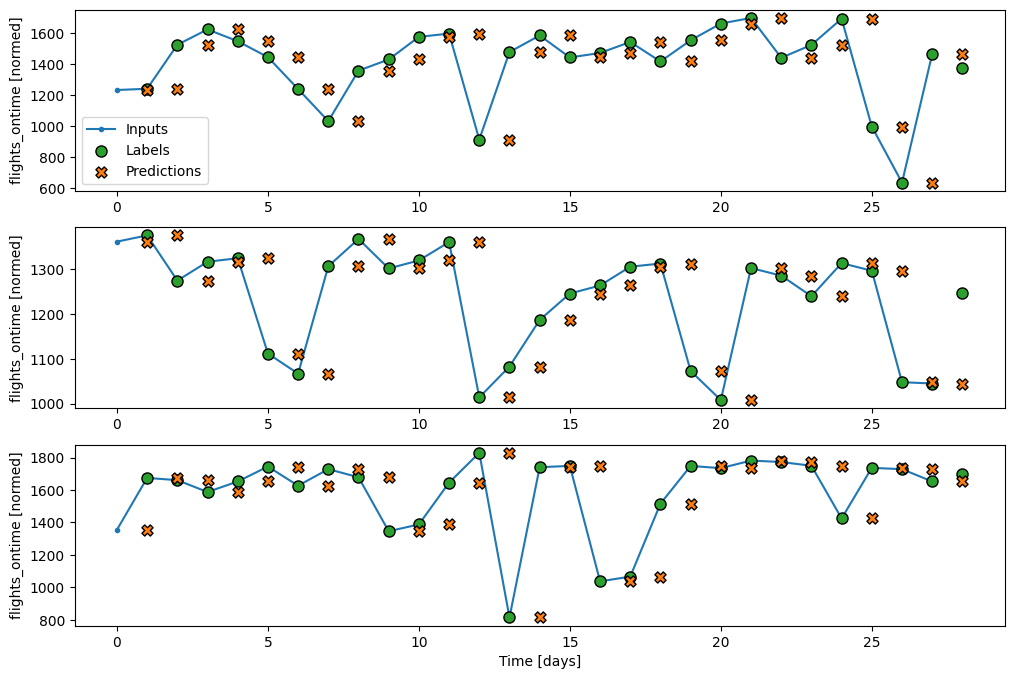

In [21]:
wide_window.plot(baseline)

# Linear Model - predict one day into the future

In [22]:
linear = Sequential([Dense(units=1)])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)
# print('Output shape:', linear.predict(single_step_window.example[0]).shape) # Another way of predicting

Input shape: (32, 1, 105)
Output shape: (32, 1, 1)



### Build linear hypermodel

In [27]:
def build_linear_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    
    model = Sequential()
    model.add(Dense(units=1, kernel_regularizer=L2(l2_reg)))
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])
    return model

### Build linear hypermodel tuners

In [28]:
# Delete logs directory
!rm -rf logs/flights_ontime/time_series/LinearDense

DenseLinear_tuner_HB = kt.Hyperband(build_linear_model,
                        objective='val_loss',
                        max_epochs=100,
                        factor=3,
                        directory='logs/flights_ontime/time_series/LinearDense',
                        project_name='hyperband_tuner')

early_stopping_HB = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

DenseLinear_tuner_HB.search(single_step_window.train, 
             epochs=10, 
             validation_data=single_step_window.val,
             callbacks=[early_stopping_HB])

Trial 254 Complete [00h 00m 09s]
val_loss: 53965.89453125

Best val_loss So Far: 33601.52734375
Total elapsed time: 00h 05m 14s


### Get best hyperparameters, build and train the model

In [29]:
best_hps = DenseLinear_tuner_HB.get_best_hyperparameters(num_trials=1)[0]
DenseLinear = DenseLinear_tuner_HB.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = DenseLinear.fit(single_step_window.train, 
                    epochs=500, 
                    validation_data=single_step_window.val, 
                    callbacks=[early_stopping],
                    verbose=0)

# Dense Linear Model Validation performance
I'm unable to get Sklearn's metrics to agree with those from Keras model.evaluate. I suspect the y_true and y_pred are mis-aligned. Consequently, I removed the 'flights_ontime' target from the preprocessor scaler, so that the MSE, MAE, and MAPE from the evaluate method are based on the raw data scale. This means we can compare Keras models for predicting flights_ontime to other models without having to inverse transform the predictions before calcluating metrics with Sklearn. I "think" the only downside is potentially slower model fits.

In [32]:
val_performance['DenseLinear_Keras_evaluate'] = {
    'MSE': DenseLinear.evaluate(single_step_window.val, verbose=0)[0],
    'MAE': DenseLinear.evaluate(single_step_window.val, verbose=0)[1],
    'MAPE': DenseLinear.evaluate(single_step_window.val, verbose=0)[2]
    }

y_true = np.concatenate([y for x, y in single_step_window.val], axis=0).reshape(-1,1)
y_pred = DenseLinear.predict(single_step_window.val).reshape(-1,1)


val_performance['DenseLinear_Sklearn'] = {
    'MSE': mean_squared_error(y_true, y_pred),
    'MAE': mean_absolute_error(y_true, y_pred),
    'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

print("Validation set performance:")
print(pd.DataFrame(val_performance).T.round(2))

11/11 [==============================] - 0s 446us/step
Validation set performance:
                                 MSE     MAE   MAPE
baseline_Keras_evaluate     46363.16  140.40  14.13
baseline_Sklearn            46363.15  140.40   0.13
DenseLinear_Keras_evaluate  33040.06  122.00  13.01
DenseLinear_Sklearn         59858.82  165.03   0.18


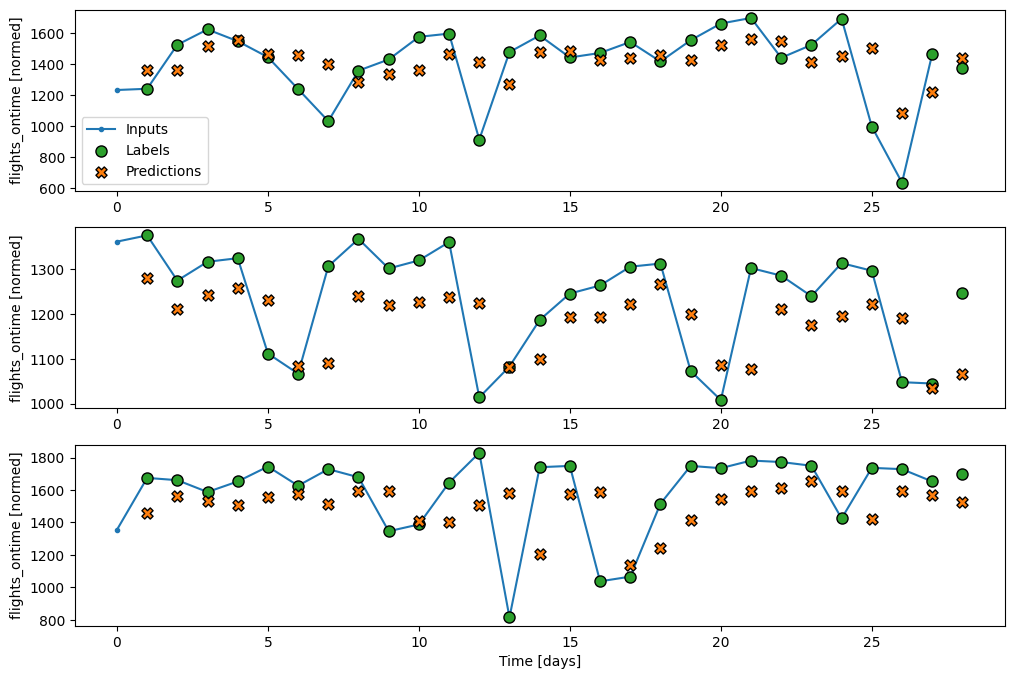

In [33]:
wide_window.plot(DenseLinear)

In [34]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss='mean_squared_error',
                optimizer=Adam(),
                metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

# LSTM Model

In [35]:
# Build LSTM Hypermodel
def build_lstm_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    
    model = Sequential([tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=L2(l2_reg)),
                        tf.keras.layers.Dense(units=1)])
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])
    return model

Trial 10 Complete [00h 00m 45s]
val_loss: 669912.1875

Best val_loss So Far: 90458.25
Total elapsed time: 00h 07m 12s


### Build tuners

In [51]:
# Delete logs directory
!rm -rf logs/flights_ontime/time_series/LSTM

# Hyperband tuner
LSTM7_tuner_HB = kt.Hyperband(build_lstm_model,
                        objective='val_loss',
                        max_epochs=100,
                        factor=3,
                        directory='logs/flights_ontime/time_series/LSTM',
                        project_name='hyperband_tuner')

# Random Search tuner
LSTM7_tuner_RS = kt.RandomSearch(build_lstm_model,
                        objective='val_loss',
                        max_trials=10,
                        directory='logs/flights_ontime/time_series/LSTM',
                        project_name='random_search_tuner')

### Search hyperparameter space using 7-day window

#### Hyperband tuner

In [ ]:
# early_stopping_HB = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# LSTM7_tuner_HB.search(wide_window.train,
#                      epochs=10,
#                      validation_data=wide_window.val,
#                      callbacks=[early_stopping_HB])

#### Random search tuner

In [52]:
early_stopping_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
LSTM7_tuner_RS.search(wide_window.train,
                     epochs=100,
                     validation_data=wide_window.val,
                     callbacks=[early_stopping_RS])

Trial 10 Complete [00h 00m 40s]
val_loss: 593686.0625

Best val_loss So Far: 593686.0625
Total elapsed time: 00h 07m 02s


### Build and train best LSTM 7-day time series model

In [53]:
# Get best hyperparameters
best_hps = LSTM7_tuner_RS.get_best_hyperparameters(num_trials=1)[0]
LSTM7 = LSTM7_tuner_RS.hypermodel.build(best_hps)

# build and train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = LSTM7.fit(wide_window.train,
                    epochs=500, 
                    validation_data=wide_window.val, 
                    callbacks=[early_stopping],
                    verbose=0)

### Validation metrics for 7-day LSTM time series

In [54]:
# r-square score
y_true = np.concatenate([y for x, y in wide_window.val], axis=0).reshape(-1,1)
y_pred = LSTM7.predict(wide_window.val).reshape(-1)

val_performance['LSTM7_Sklearn'] = {
    'MSE': mean_squared_error(y_true, y_pred),
    'MAE': mean_absolute_error(y_true, y_pred),
    'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }


val_performance['LSTM7_Keras_evaluate'] = {
    'MSE': LSTM7.evaluate(wide_window.val, verbose=0)[0],
    'MAE': LSTM7.evaluate(wide_window.val, verbose=0)[1],
    'MAPE': LSTM7.evaluate(wide_window.val, verbose=0)[2]
    }

10/10 [==============================] - 0s 3ms/step


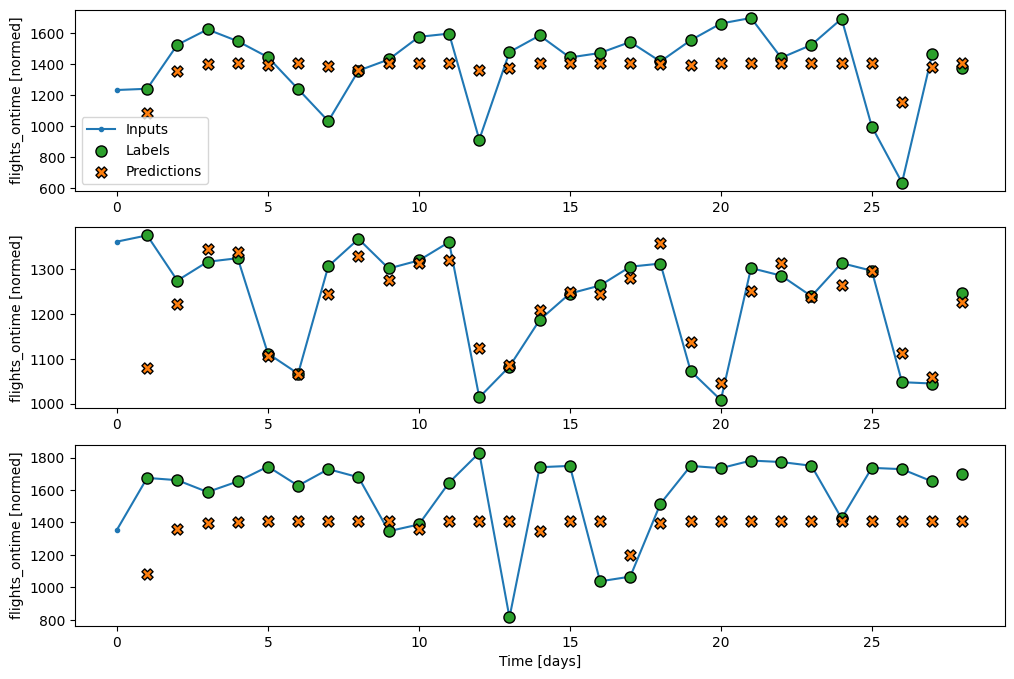

In [55]:
wide_window.plot(LSTM7)

### Export CSV of validation metrics for time series models

In [57]:
# Create dataframe of validation set performance across models
df = pd.DataFrame(val_performance).T
df['model_library'] = df.index
df['model_library'] = df['model_library'].str.replace('_evaluate', '')
df[['model', 'library']] = df['model_library'].str.split('_', expand=True)
df = df.drop(columns='model_library')
df = df[['model', 'library', 'MSE', 'MAE', 'MAPE']]
df = df.reset_index(drop=True)

print("Validation set performance:")
print(df)

Validation set performance:
         model  library           MSE         MAE       MAPE
0     baseline    Keras  46363.156250  140.398804  14.131409
1     baseline  Sklearn  46363.154762  140.398810   0.130834
2  DenseLinear    Keras  33040.062500  121.998466  13.007387
3  DenseLinear  Sklearn  59858.816406  165.029907   0.175445
4         LSTM  Sklearn  62974.535156  158.104202   0.181322
5         LSTM    Keras  39110.972656  127.453941  13.972805
6        LSTM7  Sklearn  55709.324219  153.688141   0.173284
7        LSTM7    Keras  36895.808594  125.670799  13.958133


In [58]:
df.to_csv('model_output/TimeSeries_results.csv')